In [1]:
from google.cloud import aiplatform
import os

gemini = os.getenv("GEMINI_API_KEY")
location = os.getenv("location")
location_processor = os.getenv("location_processor")
project_id = os.getenv("project_id")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= 'preprocessing_credentials.json'

aiplatform.init(project=project_id, location=location)

Agentic Segmentation:

In [ ]:
import os
import json
import re
import PyPDF2
from langchain_google_genai import GoogleGenerativeAI

# Get requirements

gemini = os.getenv("GEMINI_API_KEY")
location = os.getenv("location")
location_processor = os.getenv("location_processor")
project_id = os.getenv("project_id")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= 'preprocessing_credentials.json'


def initialize_model():
    model = GoogleGenerativeAI(
        model="gemini-1.0-pro",
        google_api_key=gemini,
        temperature=0.1
    )
    return model

def clean_response(response_str):
    """
    Cleans the response string by removing the code block markers and then attempts to convert it to JSON.
    """
    # Remove the code block markers (start and end)
    response_str = re.sub(r'^```json\n', '', response_str)
    response_str = re.sub(r'```$', '', response_str).strip()
    
    # Attempt to parse the cleaned string into a JSON object
    try:
        response_json = json.loads(response_str)
        return response_json
    except json.JSONDecodeError:
        print("Error parsing the response as JSON, response was:", response_str)
        return {"findings": [], "metadata": {}}

def chunk_and_clean_text(model, raw_text):
    prompt = """
    You are a highly capable AI model tasked with cleaning and chunking the provided text.
    Please return the response in JSON format with two keys:
    - "findings": A list of valid claims or facts related to muscle training, nutrition, gym, biology, etc, this claims should be unique and shall not be a simple fact, it should be worth getting from a "secietific" research paper.
    - "metadata": A dictionary containing the "title" key with the paper's title.
    Here is the input text: {raw_text}
    """

    # Get response from Gemini model (in string format)
    response_str = model(prompt.format(raw_text=raw_text))
        
    # Clean and parse the response string into a JSON object
    response_json = clean_response(response_str)
    
    findings = response_json.get("findings", [])
    metadata = response_json.get("metadata", {})
    
    return {"findings": findings, "metadata": metadata}

def process_pages(pages):
    model = initialize_model()
    full_response = {"findings": [], "metadata": {}}
    
    for page in pages:
        print(f"Processing page {pages.index(page) + 1}...")
        response = chunk_and_clean_text(model, page)
        
        # Print the response for debugging purposes
        print("Response:", response)  # Print the response to verify it's in the correct format
        
        # Merge findings from the response
        if isinstance(response, dict):
            # Append findings to full_response['findings']
            full_response["findings"].extend(response.get("findings", []))
            
            # Merge metadata if it's not already set
            if not full_response["metadata"]:
                full_response["metadata"] = response.get("metadata", {})
        else:
            print("Response is not in the expected format:", response)
    
    return full_response

# Extract text from PDF using PyPDF2
def extract_text_from_pdf(file_path):
    with open(file_path, "rb") as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        pages = []
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            page_text = page.extract_text()
            pages.append(page_text)
    return pages


# Path to your PDF file
file_path = "nutrition_research_papers/jmir-2023-1-e37667.pdf"
# Extract text from the PDF using PyPDF2
print("Extracting text from PDF using PyPDF2...")
pages = extract_text_from_pdf(file_path)
print(len(pages))
# Perform chunking and cleaning
print("Cleaning and chunking text from each page...")
final_response = process_pages(pages)

# Output the final response
print(final_response)


Applying the above to all the files in the folder:

In [6]:
import os
import json
import re
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAI
import PyPDF2

# Initialize the Gemini Pro model
def initialize_model():
    try:
        gemini = os.getenv("GEMINI_API_KEY")
        model = GoogleGenerativeAI(
            model="gemini-2.0-flash-exp",
            google_api_key=gemini,
            temperature=0.2
        )
        print("Model initialized successfully.")
        return model
    except Exception as e:
        print(f"Error initializing model: {e}")
        exit(1)

# Clean the response from Gemini Pro
def clean_response(response_str):
    response_str = re.sub(r'^```json\n', '', response_str)
    response_str = re.sub(r'```$', '', response_str).strip()
    try:
        return json.loads(response_str)
    except json.JSONDecodeError:
        print(f"Error parsing response as JSON: {response_str[:500]}")  # Log first 500 characters
        return {"findings": [], "metadata": {}}

# Chunk text and send it to Gemini Pro
def chunk_and_clean_text(model, raw_text, title="Unknown Document"):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=3000,  # Adjust to Gemini's input limit
        chunk_overlap=200  # Overlap between chunks for context preservation
    )
    chunks = text_splitter.split_text(raw_text)
    combined_response = {"findings": [], "metadata": {"title": title}}

    for idx, chunk in enumerate(chunks):
        print(f"Processing chunk {idx + 1}/{len(chunks)}...")
        prompt = f"""
        You are a highly capable AI assisting with extracting relevant information.
        - Extract valid claims or facts related to muscle training, nutrition, gym, biology, etc.
        - Return JSON with two keys:
          - "findings": List of claims/facts that should be not too simple and hold very relevant info.
          - "metadata": Dictionary with "title": "{title}" and any other relevant info.
        Here is the input text: {chunk}
        """
        try:
            response_str = model(prompt)
            response = clean_response(response_str)
            combined_response["findings"].extend(response.get("findings", []))
            if "title" in response.get("metadata", {}):
                combined_response["metadata"]["title"] = response["metadata"]["title"]
        except Exception as e:
            print(f"Error processing chunk {idx + 1}: {e}")
    
    return combined_response

# Extract text from PDF
def extract_text_from_pdf(file_path):
    try:
        with open(file_path, "rb") as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            return [page.extract_text() for page in pdf_reader.pages]
    except Exception as e:
        print(f"Error extracting text from {file_path}: {e}")
        return []

# Process all PDFs in the specified folder
def process_folder(folder_path):
    model = initialize_model()
    aggregated_results = {"findings": [], "metadata": []}
    failed_files = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".pdf"):
            print(f"\nProcessing file: {file_name}")
            file_path = os.path.join(folder_path, file_name)
            pages = extract_text_from_pdf(file_path)
            
            if not pages:
                print(f"Skipping {file_name}: No readable pages found.")
                failed_files.append(file_name)
                continue

            full_text = "\n".join(pages)
            file_response = chunk_and_clean_text(model, full_text, title=file_name)
            aggregated_results["findings"].extend(file_response.get("findings", []))
            aggregated_results["metadata"].append({
                "file_name": file_name,
                **file_response.get("metadata", {})
            })
            print(f"Finished processing {file_name}. Metadata: {file_response.get('metadata', {})}")
            print(f"Total findings so far: {len(aggregated_results['findings'])}, {len(aggregated_results['metadata'])}")
            break

    print("\nProcessing complete.")
    print(f"Failed to process {len(failed_files)} files: {failed_files}")
    return aggregated_results

# Main execution
folder_path = "resistant_research_papers"  # Folder containing PDF files
print("Starting processing for folder:", folder_path)

final_results = process_folder(folder_path)
print(final_results)
# Format for embedding-friendly output
formatted_results = [
    {
        "id": idx + 1,
        "text": finding,
        "embedding": None,  # Placeholder; replace after embedding.
        "metadata": metadata
    }
    for idx, (finding, metadata) in enumerate(zip(final_results["findings"], final_results["metadata"]))
]
print(formatted_results)
# Save the formatted results to JSON
output_file_path = "formatted_embeddings_input.json"
with open(output_file_path, "w") as output_file:
    json.dump(formatted_results, output_file, indent=4)

print(f"\nResults saved to {output_file_path}.")
print(f"Total findings: {len(formatted_results)}")


Starting processing for folder: resistant_research_papers
Model initialized successfully.

Processing file: ijerph-16-04897.pdf
Processing chunk 1/21...
Processing chunk 2/21...
Processing chunk 3/21...
Processing chunk 4/21...
Processing chunk 5/21...
Processing chunk 6/21...
Processing chunk 7/21...
Processing chunk 8/21...
Processing chunk 9/21...
Processing chunk 10/21...
Processing chunk 11/21...


Retrying langchain_google_genai.llms._completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


Processing chunk 12/21...


Retrying langchain_google_genai.llms._completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


Processing chunk 13/21...


Retrying langchain_google_genai.llms._completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.llms._completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.llms._completion_with_retry.<locals>._completion_with_retry in 8.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


Processing chunk 14/21...
Processing chunk 15/21...
Processing chunk 16/21...
Processing chunk 17/21...
Processing chunk 18/21...
Processing chunk 19/21...
Processing chunk 20/21...
Processing chunk 21/21...
Error parsing response as JSON: {
  "findings": [
    "Pre-exhaustion techniques affect patterns of muscular activity in the flat bench press.",
    "Specialized training techniques can be used to maximize muscle hypertrophy."
  ],
  "metadata": {
    "title": "ijerph-16-04897.pdf",
    "references": [
      {
        "authors": "Golas, A.; Maszczyk, A.; Pietraszewski, P.; Stastny, P.; Tufano, J.J.; Zaj ˛ ac, A.",
        "title": "E ects of Pre-exhaustion on the Patterns of Muscular Activity in the Flat Bench Press.",
      
Finished processing ijerph-16-04897.pdf. Metadata: {'title': 'ijerph-16-04897.pdf'}
Total findings so far: 225, 1

Processing complete.
Failed to process 0 files: []
{'findings': ['Effective hypertrophy-oriented resistance training (RT) should comprise a comb

Cleanning the collected data:

In [2]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

# Function to clean data
def clean_data(data):
    """
    Cleans the text data by removing duplicates, very basic text, and normalizing content.
    Args:
        data (list): List of text rows.
    Returns:
        list: Cleaned text rows.
    """
    print("Starting data cleaning...")
    
    # Convert list to DataFrame
    df = pd.DataFrame(data, columns=["text"])
    print(f"Initial data loaded. Total entries: {len(df)}")
    
    # Remove duplicates
    df = df.drop_duplicates(subset=["text"])
    print(f"Removed duplicates. Remaining entries: {len(df)}")
    
    # Remove short or basic text (less than 5 words or very generic)
    df = df[df["text"].apply(lambda x: len(x.split()) > 5)]
    print(f"Removed short/basic text. Remaining entries: {len(df)}")
    
    # Normalize text: remove special characters, extra spaces
    df["text"] = df["text"].str.replace(r"[^\w\s]", "", regex=True).str.strip()
    print("Normalized text.")
    
    # Optional: Remove highly similar rows using cosine similarity
    print("Calculating cosine similarity for identifying similar rows...")
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(df["text"])
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # Identify rows with high similarity
    to_remove = set()
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] > 0.9:  # Threshold for similarity
                to_remove.add(j)
    
    print(f"Identified {len(to_remove)} similar rows to remove.")
    
    # Keep only unique rows
    df = df.iloc[list(set(range(len(df))) - to_remove)]
    print(f"Final cleaned data. Remaining entries: {len(df)}")
    
    return df["text"].tolist()

# Function to embed text using Vertex AI's Text Embedding Model
def embed_text_vertex(cleaned_text):
    """
    Embeds text using Vertex AI's Text Embedding Model.
    Args:
        cleaned_text (list): List of cleaned text rows.
    Returns:
        pd.DataFrame: DataFrame with original text and embeddings.
    """
    print("Starting embedding process...")

    # Initialize the embedding model
    model = TextEmbeddingModel.from_pretrained("textembedding-gecko@003")
    print("Embedding model initialized.")
    
    embeddings = []
    for idx, text in enumerate(cleaned_text):
        print(f"Embedding text {idx + 1}/{len(cleaned_text)}...")
        input_obj = TextEmbeddingInput(text=text)
        try:
            response = model.get_embeddings([input_obj])
            embedding = response[0].values
            embeddings.append(embedding)
            print(f"Successfully embedded text {idx + 1}")
        except Exception as e:
            print(f"Error embedding text {idx + 1}: {e}")
            embeddings.append(None)

    print("Embedding process completed.")
    
    # Create DataFrame with embeddings
    df_embeddings = pd.DataFrame({
        "text": cleaned_text,
        "embedding": embeddings
    })

    return df_embeddings

# Main function
if __name__ == "__main__":
    # Path to the JSON file created by the collection script
    input_file_path = "aggregated_results_resistant.json"
    print(f"Loading data from {input_file_path}...")

    # Load the JSON file
    with open(input_file_path, "r") as input_file:
        aggregated_results = json.load(input_file)
    
    print(f"Data loaded. Total findings: {len(aggregated_results['findings'])}")
    
    # Clean the findings
    print("Cleaning text data...")
    cleaned_findings = clean_data(aggregated_results["findings"])
    print(f"Cleaned findings: {len(cleaned_findings)} entries remain.")

    # Embed the cleaned text
    print("Embedding text data...")
    embedded_results = embed_text_vertex(cleaned_findings)
    
    # Save the embeddings to a new JSON file
    output_file_path = "embedded_results_resistant.json"
    embedded_results.to_json(output_file_path, orient="records", indent=4)
    
    print(f"Embedding process completed. Results saved to {output_file_path}.")


Loading data from aggregated_results_resistant.json...
Data loaded. Total findings: 1438
Cleaning text data...
Starting data cleaning...
Initial data loaded. Total entries: 1438
Removed duplicates. Remaining entries: 1435
Removed short/basic text. Remaining entries: 1431
Normalized text.
Calculating cosine similarity for identifying similar rows...
Identified 5 similar rows to remove.
Final cleaned data. Remaining entries: 1426
Cleaned findings: 1426 entries remain.
Embedding text data...
Starting embedding process...
Embedding model initialized.
Embedding text 1/1426...
Successfully embedded text 1
Embedding text 2/1426...
Successfully embedded text 2
Embedding text 3/1426...
Successfully embedded text 3
Embedding text 4/1426...
Successfully embedded text 4
Embedding text 5/1426...
Successfully embedded text 5
Embedding text 6/1426...
Successfully embedded text 6
Embedding text 7/1426...
Successfully embedded text 7
Embedding text 8/1426...
Successfully embedded text 8
Embedding text 

Embedding Visuals:

Loaded 4008 texts with embeddings.
Starting similarity search...
Found 434 pairs with similarity >= 0.95.

Most Similar Pairs (with >= 95% similarity):
Text 5 and Text 92 have similarity of 0.96
Text 7 and Text 28 have similarity of 0.95
Text 18 and Text 27 have similarity of 0.97
Text 21 and Text 65 have similarity of 0.96
Text 28 and Text 50 have similarity of 0.96
Text 28 and Text 54 have similarity of 0.95
Text 31 and Text 32 have similarity of 0.98
Text 33 and Text 51 have similarity of 0.95
Text 36 and Text 52 have similarity of 0.98
Text 36 and Text 69 have similarity of 0.98


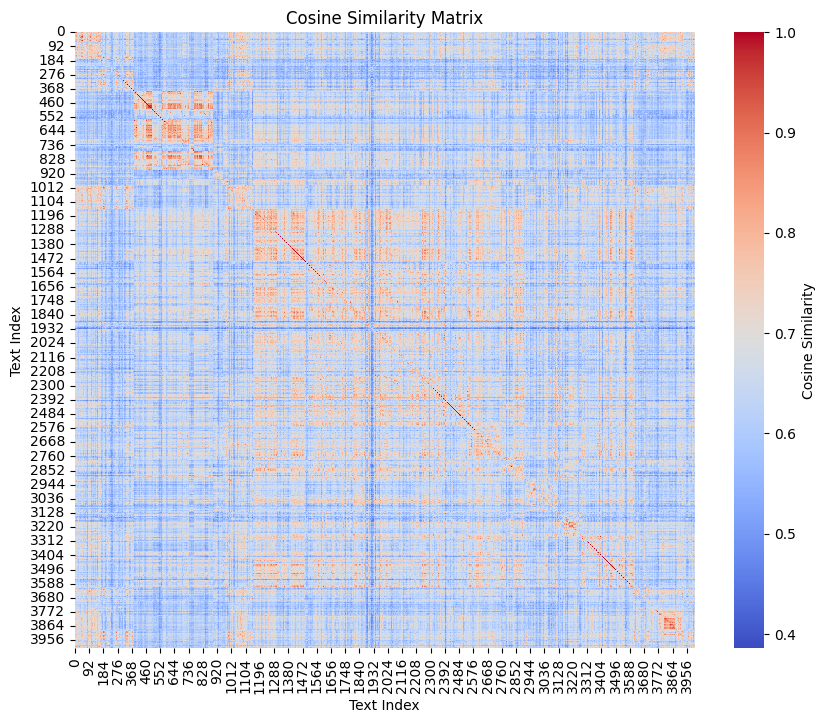

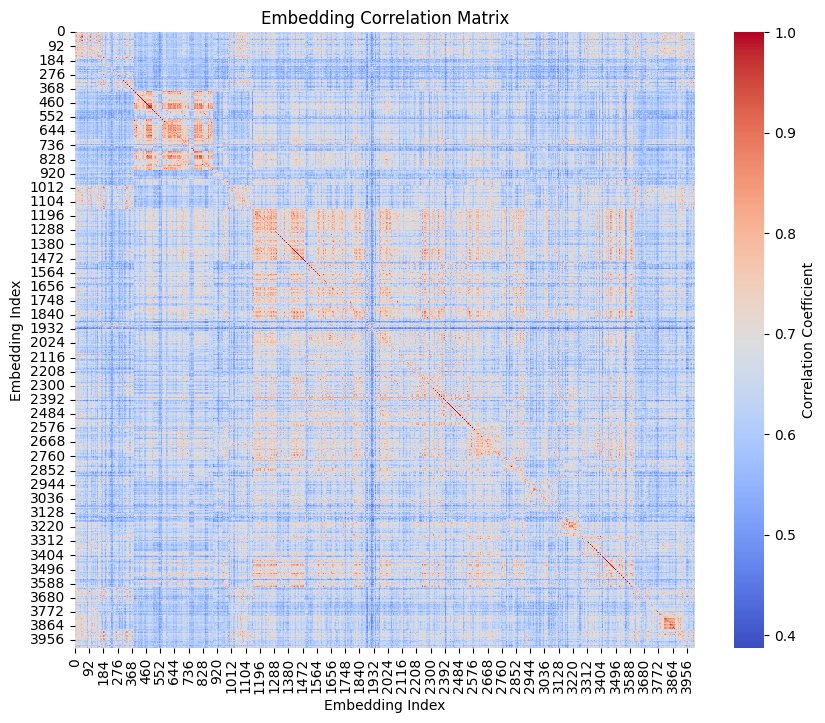

Calculating similarity distribution...


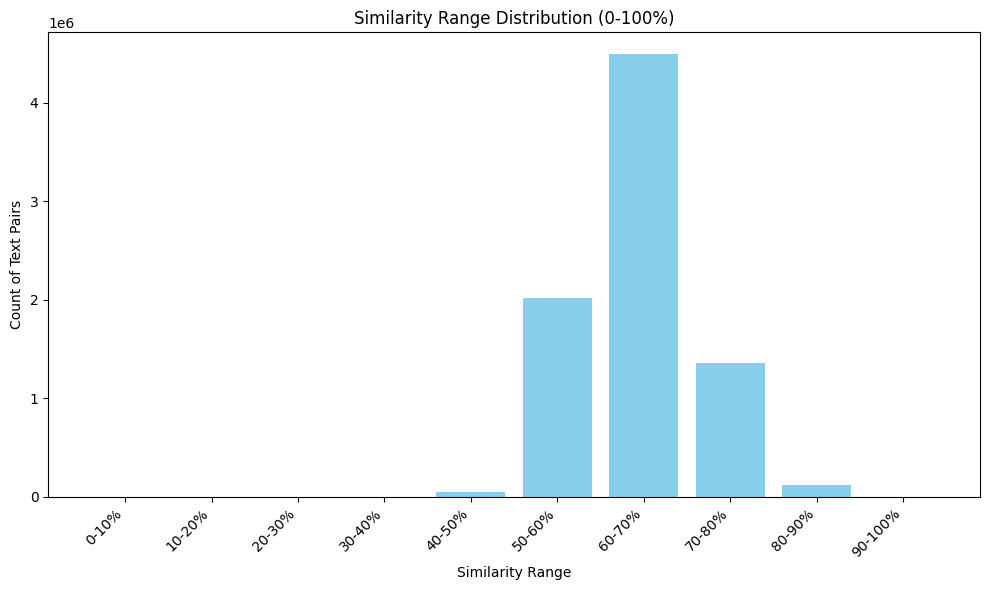

In [15]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load the embeddings data
def load_embeddings(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    
    embeddings = []
    texts = []
    
    # Extract embeddings and texts
    for entry in data:
        embeddings.append(entry['embedding'])  # Assuming 'embedding' key contains the vector
        texts.append(entry['text'])            # Assuming 'text' key contains the actual text
    
    return texts, np.array(embeddings)

# Step 2: Find similar texts using cosine similarity
def find_similar_texts(embeddings, threshold=0.95):
    print("Starting similarity search...")
    
    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)
    
    # Create a list to store similar text pairs above the threshold
    similar_pairs = []
    
    # Identify pairs with similarity above the threshold
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):  # Compare only the upper half (no duplicates)
            if similarity_matrix[i, j] >= threshold:
                similar_pairs.append((i, j, similarity_matrix[i, j]))  # (text index 1, text index 2, similarity score)
    
    print(f"Found {len(similar_pairs)} pairs with similarity >= {threshold}.")
    return similar_pairs, similarity_matrix

# Step 3: Plot similarity matrix using heatmap
def plot_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(10, 8))
    
    # Create a heatmap of the similarity matrix
    sns.heatmap(similarity_matrix, cmap='coolwarm', annot=False, fmt=".2f", cbar_kws={'label': 'Cosine Similarity'})
    
    plt.title("Cosine Similarity Matrix")
    plt.xlabel("Text Index")
    plt.ylabel("Text Index")
    plt.show()

# Step 4: Plot the correlation matrix of the embeddings
def plot_correlation_matrix(embeddings):
    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(embeddings)
    
    plt.figure(figsize=(10, 8))
    
    # Create a heatmap for the correlation matrix
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
    
    plt.title("Embedding Correlation Matrix")
    plt.xlabel("Embedding Index")
    plt.ylabel("Embedding Index")
    plt.show()

# Step 5: Calculate and plot the similarity range distribution
def plot_similarity_distribution(similarity_matrix):
    print("Calculating similarity distribution...")
    
    # Flatten the similarity matrix to get all pairwise similarity scores
    similarity_values = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]  # Get upper triangle values (excluding diagonal)
    
    # Create bins for similarity ranges (0-10, 10-20, ..., 90-100)
    bins = np.arange(0, 1.1, 0.1)
    bin_labels = [f"{int(b * 100)}-{int((b + 0.1) * 100)}%" for b in bins[:-1]]
    
    # Compute the histogram of similarity values
    similarity_hist, _ = np.histogram(similarity_values, bins=bins)
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(bin_labels, similarity_hist, width=0.8, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Similarity Range")
    plt.ylabel("Count of Text Pairs")
    plt.title("Similarity Range Distribution (0-100%)")
    plt.tight_layout()
    plt.show()

# Step 6: Main pipeline to load, analyze, and visualize embeddings
def main():
    file_path = "embedded_results_resistant.json"  # Path to the embedded result JSON file
    
    # Load the embeddings data
    texts, embeddings = load_embeddings(file_path)
    print(f"Loaded {len(texts)} texts with embeddings.")
    
    # Find similar texts with 95% similarity or higher
    similar_pairs, similarity_matrix = find_similar_texts(embeddings, threshold=0.95)
    
    # Show some of the most similar pairs
    if similar_pairs:
        print("\nMost Similar Pairs (with >= 95% similarity):")
        for i, j, score in similar_pairs[:10]:  # Print top 10 similar pairs
            print(f"Text {i+1} and Text {j+1} have similarity of {score:.2f}")
    
    # Visualize the similarity matrix
    plot_similarity_matrix(similarity_matrix)
    
    # Visualize the correlation matrix of embeddings
    plot_correlation_matrix(embeddings)
    
    # Plot the similarity distribution
    plot_similarity_distribution(similarity_matrix)

# Execute the pipeline
if __name__ == "__main__":
    main()


Gathering the embedding for all the files and creating the vector db info:

In [ ]:
import os
import json
import re
import PyPDF2
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAI
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from google.cloud import aiplatform
from datetime import datetime
import numpy as np

# Load environment variables
load_dotenv()
gemini_api_key = os.getenv("GOOGLE_API_KEY")
aiplatform_project = os.getenv("PROJECT_ID")
aiplatform_location = os.getenv("LOCATION_ID")
processor_id = os.getenv("PROCESSOR_ID")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "preprocessing_credentials.json"

# Initialize Vertex AI
aiplatform.init(project=aiplatform_project, location=aiplatform_location)

# Function to initialize Gemini model
def initialize_model():
    print("Initializing Gemini model...")
    model = GoogleGenerativeAI(
        model="gemini-1.0-pro",
        google_api_key=gemini_api_key,
        temperature=0.1,
    )
    print("Gemini model initialized successfully.")
    return model

# Function to generate embeddings
def generate_embeddings(text):
    try:
        if not text.strip():
            print(f"Skipped embedding: Text is empty or whitespace.")
            return None

        print(f"Generating embedding for text: {text[:50]}...")
        model = TextEmbeddingModel.from_pretrained("textembedding-gecko@003")
        input_obj = TextEmbeddingInput(text=text)
        embeddings = model.get_embeddings([input_obj])
        print("Embedding generated successfully.")
        return embeddings[0].values
    except Exception as e:
        print(f"Error generating embedding for text: {text[:50]}... Error: {e}")
        return None

# Function to clean Gemini response
def clean_response(response_str):
    print("Cleaning Gemini response...")
    response_str = re.sub(r'^```json\n', '', response_str)
    response_str = re.sub(r'```$', '', response_str).strip()

    try:
        response_json = json.loads(response_str)
        print("Response cleaned and converted to JSON.")
        return response_json
    except json.JSONDecodeError:
        print("Error parsing the response as JSON, response was:", response_str)
        return {"findings": [], "metadata": {}}

# Function to process text with Gemini
def chunk_and_clean_text(model, raw_text):
    prompt = """
    You are a highly capable AI model tasked with cleaning and chunking the provided text.
    Please return the response in JSON format with two keys:
    - "findings": A list of valid claims or facts related to muscle training, nutrition, gym, biology, etc.
    - "metadata": A dictionary containing the "title" key with the paper's title.
    Here is the input text: {raw_text}
    """

    print(f"Processing text chunk: {raw_text[:100]}...")
    response_str = model(prompt.format(raw_text=raw_text))
    response_json = clean_response(response_str)

    findings = response_json.get("findings", [])
    metadata = response_json.get("metadata", {})
    print(f"Processed text with findings: {len(findings)} items.")
    return {"findings": findings, "metadata": metadata}

# Function to process pages of a PDF
def process_pages(model, pages):
    full_response = {}
    print("Starting to process PDF pages...")

    for idx, page in enumerate(pages):
        print(f"Processing page {idx + 1}...")
        response = chunk_and_clean_text(model, page)

        title = response["metadata"].get("title", f"Untitled Page {idx + 1}")
        if title not in full_response:
            full_response[title] = []
        full_response[title].extend(response["findings"])
    print("All pages processed.")
    return full_response

# Function to extract text from PDF
def extract_text_from_pdf(file_path):
    print(f"Extracting text from PDF: {file_path}...")
    with open(file_path, "rb") as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        pages = [page.extract_text() for page in pdf_reader.pages]
    print(f"Extracted {len(pages)} pages from PDF.")
    return pages

# Function to process findings with embeddings
def process_findings_with_embeddings(findings_by_title):
    processed = {}
    print("Processing findings with embeddings...")

    for title, findings in findings_by_title.items():
        print(f"Processing title: {title} with {len(findings)} findings...")
        embeddings_list = []

        for finding in findings:
            embedding = generate_embeddings(finding)
            if embedding:
                embeddings_list.append({"text": finding, "embedding": embedding})
            else:
                print(f"Embedding failed for finding: '{finding}' under title: '{title}'")

        processed[title] = embeddings_list
        print(f"Processed title: {title} with {len(embeddings_list)} embeddings.")
    return processed

# Main pipeline function
def process_folder(folder_path):
    model = initialize_model()
    total_data = {"processed": {}, "completed_files": []}

    for file_name in os.listdir(folder_path):
        try:
            file_path = os.path.join(folder_path, file_name)
            if file_name in total_data["completed_files"]:
                print(f"Skipping already completed file: {file_name}")
                continue

            print(f"Processing file: {file_name}...")
            pages = extract_text_from_pdf(file_path)
            findings_by_title = process_pages(model, pages)
            embeddings_data = process_findings_with_embeddings(findings_by_title)

            total_data["processed"].update(embeddings_data)
            total_data["completed_files"].append(file_name)
            print(f"File {file_name} processed successfully.")

            # Save progress after each file
            with open("progress_with_embeddings.json", "w") as f:
                json.dump(total_data, f, indent=4)
            print("Progress saved.")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    return total_data

if __name__ == "__main__":
    folder_path = "nutrition_research_papers"
    print("Starting pipeline...")
    start_time = datetime.now()
    result = process_folder(folder_path)
    print(f"Pipeline completed in {datetime.now() - start_time}.")
    print("Final result:", result)


In [ ]:
import os
import json
import re
import PyPDF2
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAI
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from google.cloud import aiplatform
from datetime import datetime

# Load environment variables
load_dotenv()
gemini_api_key = os.getenv("GEMINI_API_KEY")
aiplatform_project = os.getenv("PROJECT_ID")
aiplatform_location = os.getenv("LOCATION_ID")
processor_id = os.getenv("PROCESSOR_ID")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "preprocessing_credentials.json"

# Initialize Vertex AI
aiplatform.init(project=aiplatform_project, location=aiplatform_location)

# Initialize Gemini model
def initialize_model():
    print("Initializing Gemini model...")
    model = GoogleGenerativeAI(
        model="gemini-1.0-pro",
        google_api_key=gemini_api_key,
        temperature=0.1,
    )
    print("Gemini model initialized successfully.")
    return model

# Generate embeddings using Vertex AI's text embedding model
def generate_embeddings(text):
    try:
        if not text.strip():
            print(f"Skipped embedding: Text is empty or whitespace.")
            return None

        print(f"Generating embedding for text: {text[:50]}...")
        model = TextEmbeddingModel.from_pretrained("textembedding-gecko@003")
        input_obj = TextEmbeddingInput(text=text)
        embeddings = model.get_embeddings([input_obj])
        print("Embedding generated successfully.")
        return embeddings[0].values
    except Exception as e:
        print(f"Error generating embedding for text: {text[:50]}... Error: {e}")
        return None

# Clean the Gemini model's response
def clean_response(response_str):
    print("Cleaning Gemini response...")
    response_str = re.sub(r'^```json\n', '', response_str)
    response_str = re.sub(r'```$', '', response_str).strip()

    try:
        response_json = json.loads(response_str)
        print("Response cleaned and converted to JSON.")
        return response_json
    except json.JSONDecodeError:
        print("Error parsing the response as JSON, response was:", response_str)
        return {"findings": [], "metadata": {}}

# Chunk and clean text from the raw input
def chunk_and_clean_text(model, raw_text):
    prompt = """
    You are a highly capable AI model tasked with cleaning and chunking the provided text.
    Please return the response in JSON format with two keys:
    - "findings": A list of valid claims or facts related to muscle training, nutrition, gym, biology, etc.
    - "metadata": A dictionary containing the "title" key with the paper's title.
    Here is the input text: {raw_text}
    """

    print(f"Processing text chunk: {raw_text[:100]}...")
    response_str = model(prompt.format(raw_text=raw_text))
    response_json = clean_response(response_str)

    findings = response_json.get("findings", [])
    metadata = response_json.get("metadata", {})
    print(f"Processed text with findings: {len(findings)} items.")
    return {"findings": findings, "metadata": metadata}

# Process all pages of a PDF
def process_pages(model, pages):
    full_response = {}
    print("Starting to process PDF pages...")

    for idx, page in enumerate(pages):
        print(f"Processing page {idx + 1}...")
        response = chunk_and_clean_text(model, page)

        title = response["metadata"].get("title", f"Untitled Page {idx + 1}")
        if title not in full_response:
            full_response[title] = []
        full_response[title].extend(response["findings"])
    print("All pages processed.")
    return full_response

# Extract text from a PDF file
def extract_text_from_pdf(file_path):
    print(f"Extracting text from PDF: {file_path}...")
    with open(file_path, "rb") as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        pages = [page.extract_text() for page in pdf_reader.pages]
    print(f"Extracted {len(pages)} pages from PDF.")
    return pages

# Process findings with embeddings
def process_findings_with_embeddings(findings_by_title):
    processed = {}
    print("Processing findings with embeddings...")

    for title, findings in findings_by_title.items():
        print(f"Processing title: {title} with {len(findings)} findings...")
        embeddings_list = []

        for finding in findings:
            embedding = generate_embeddings(finding)
            if embedding:
                embeddings_list.append({"text": finding, "embedding": embedding})
            else:
                print(f"Embedding failed for finding: '{finding}' under title: '{title}'")

        processed[title] = embeddings_list
        print(f"Processed title: {title} with {len(embeddings_list)} embeddings.")
    return processed

# Main function to process all PDFs in a folder
def process_folder(folder_path):
    model = initialize_model()
    total_data = {"processed": {}, "completed_files": []}

    for file_name in os.listdir(folder_path):
        try:
            file_path = os.path.join(folder_path, file_name)
            if file_name in total_data["completed_files"]:
                print(f"Skipping already completed file: {file_name}")
                continue

            print(f"Processing file: {file_name}...")
            pages = extract_text_from_pdf(file_path)
            findings_by_title = process_pages(model, pages)
            embeddings_data = process_findings_with_embeddings(findings_by_title)

            total_data["processed"].update(embeddings_data)
            total_data["completed_files"].append(file_name)
            print(f"File {file_name} processed successfully.")

            # Save progress after each file
            with open("progress_with_embeddings.json", "w") as f:
                json.dump(total_data, f, indent=4)
            print("Progress saved.")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    return total_data

if __name__ == "__main__":
    folder_path = "nutrition_research_papers"  # Replace with your folder path
    print("Starting pipeline...")
    start_time = datetime.now()
    result = process_folder(folder_path)
    print(f"Pipeline completed in {datetime.now() - start_time}.")
    print("Final result:", result)
